# Clean version of likelihood analysis

In [1]:
from matplotlib import pyplot as plt
import scipy.interpolate
import pandas as pd
import random
import numpy as np
import sys
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.stats import chi2
import matplotlib.path as mpltPath
import matplotlib as mpl

#Set Plotting Parameters
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rc('font', family='serif', size=18)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

import warnings
warnings.filterwarnings("ignore")

### Get signal and background redshift distributions

In [45]:
dataset = 'IC180103_dp806' #['IC170922_dp802', 'IC180103_dp806']
data_dir = '/Users/rmorgan/Research/des/project/%s' %dataset
plot_data_dir = 'plot_data'


In [46]:
signal_z = pd.read_csv(data_dir + '/%s/pdf_z.csv' %plot_data_dir)['Z'].values
detected = pd.read_csv(data_dir + '/%s/pdf_detected.csv' %plot_data_dir)['events'].values
bg_z = pd.read_csv(data_dir + '/%s/bkg_base_z_array.csv' %plot_data_dir)['Z'].values
total_bg = pd.read_csv(data_dir + '/%s/n_events_total.csv' %plot_data_dir)['events'].values
cc_bg = pd.read_csv(data_dir + '/%s/n_events_cc.csv' %plot_data_dir)['events'].values

In [47]:
detected_l1 = detected.copy()
detected_l0 = detected.copy() * 0.0
detected_l3 = detected.copy() * 0.3

#clean data of negative or zero values
detected = np.asarray([0.00001 if x <= 0.0 else x for x in detected])
total_bg = np.asarray([0.00001 if x <= 0.0 else x for x in total_bg])
cc_bg = np.asarray([0.00001 if x <= 0.0 else x for x in cc_bg])

#Remove the factor the 90% localization region from BG
if dataset == 'IC170922_dp802': 
    eff_area = 0.97
    event_num = 1
elif dataset == 'IC180103_dp806': 
    eff_area = 0.57
    event_num = 2
cc_bg = cc_bg / eff_area
total_bg = total_bg / eff_area

### Display redshift distributions

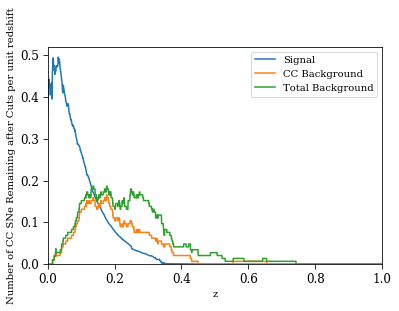

In [48]:
plt.figure()
plt.plot(signal_z, detected, label='Signal')
plt.plot(bg_z, cc_bg, label='CC Background')
plt.plot(bg_z, total_bg, label='Total Background')
plt.xlabel('z')
plt.ylabel('Number of CC SNe Remaining after Cuts per unit redshift')
plt.xlim(0.,1.)
plt.ylim(0.,)
plt.legend()
plt.show()

### Make and position DECam field of view

In [49]:
#Dictionary of CCD corners using px as the unit. Origin will be in SE corner of FoV
#Order of coordinates is BL, TL, TR, BR
boundaries = {'1': [(16996,24739), (16996,26787), (21092,26787), (21092,24739)], 
              '2': [(12747,24739), (12747,26787), (16843,26787), (16843,24739)], 
              '3': [(8498,24739), (8498,26787), (12594,26787), (12594,24739)], 
              '4': [(19120.5,22490), (19120.5,24538), (23216.5,24538), (23216.5,22490)], 
              '5': [(14871.5,22490), (14871.5,24538), (18967.5,24538), (18967.5,22490)], 
              '6': [(10622.5,22490), (10622.5,24538), (14718.5,24538), (14718.5,22490)], 
              '7': [(6373.5,22490), (6373.5,24538), (10469.5,24538), (10469.5,22490)], 
              '8': [(21245,20241), (21245,22289), (25341,22289), (25341,20241)], 
              '9': [(16996,20241), (16996,22289), (21092,22289), (21092,20241)], 
              '10': [(12747,20241), (12747,22289), (16843,22289), (16843,20241)], 
              '11': [(8498,20241), (8498,22289), (12594,22289), (12594,20241)], 
              '12': [(4249,20241), (4249,22289), (8345,22289), (8345,20241)], 
              '13': [(23369.5,17992), (23369.5,20040), (27465.5,20040), (27465.5,17992)], 
              '14': [(19120.5,17992), (19120.5,20040), (23216.5,20040), (23216.5,17992)], 
              '15': [(14871.5,17992), (14871.5,20040), (18967.5,20040), (18967.5,17992)], 
              '16': [(10622.5,17992), (10622.5,20040), (14718.5,20040), (14718.5,17992)], 
              '17': [(6373.5,17992), (6373.5,20040), (10469.5,20040), (10469.5,17992)], 
              '18': [(2124.5,17992), (2124.5,20040), (6220.5,20040), (6220.5,17992)], 
              '19': [(23369.5,15743), (23369.5,17791), (27465.5,17791), (27465.5,15743)], 
              '20': [(19120.5,15743), (19120.5,17791), (23216.5,17791), (23216.5,15743)], 
              '21': [(14871.5,15743), (14871.5,17791), (18967.5,17791), (18967.5,15743)],               
              '22': [(10622.5,15743), (10622.5,17791), (14718.5,17791), (14718.5,15743)], 
              '23': [(6373.5,15743), (6373.5,17791), (10469.5,17791), (10469.5,15743)], 
              '24': [(2124.5,15743), (2124.5,17791), (6220.5,17791), (6220.5,15743)], 
              '25': [(25494,13494), (25494,15542), (29590,15542), (29590,13494)], 
              '26': [(21245,13494), (21245,15542), (25341,15542), (25341,13494)], 
              '27': [(16996,13494), (16996,15542), (21092,15542), (21092,13494)], 
              '28': [(12747,13494), (12747,15542), (16843,15542), (16843,13494)], 
              '29': [(8498,13494), (8498,15542), (12594,15542), (12594,13494)], 
              '30': [(4249,13494), (4249,15542), (8345,15542), (8345,13494)], 
              '31': [(0,13494), (0,15542), (4096,15542), (4096,13494)],                       
              '32': [(25494,11245), (25494,13293), (29590,13293), (29590,11245)], 
              '33': [(21245,11245), (21245,13293), (25341,13293), (25341,11245)], 
              '34': [(16996,11245), (16996,13293), (21092,13293), (21092,11245)], 
              '35': [(12747,11245), (12747,13293), (16843,13293), (16843,11245)], 
              '36': [(8498,11245), (8498,13293), (12594,13293), (12594,11245)], 
              '37': [(4249,11245), (4249,13293), (8345,13293), (8345,11245)], 
              '38': [(0,11245), (0,13293), (4096,13293), (4096,11245)], 
              '39': [(23369.5,8996), (23369.5,11044), (27465.5,11044), (27465.5,8996)], 
              '40': [(19120.5,8996), (19120.5,11044), (23216.5,11044), (23216.5,8996)], 
              '41': [(14871.5,8996), (14871.5,11044), (18967.5,11044), (18967.5,8996)], 
              '42': [(10622.5,8996), (10622.5,11044), (14718.5,11044), (14718.5,8996)], 
              '43': [(6373.5,8996), (6373.5,11044), (10469.5,11044), (10469.5,8996)], 
              '44': [(2124.5,8996), (2124.5,11044), (6220.5,11044), (6220.5,8996)], 
              '45': [(23369.5,6747), (23369.5,8795), (27465.5,8795), (27465.5,6747)], 
              '46': [(19120.5,6747), (19120.5,8795), (23216.5,8795), (23216.5,6747)], 
              '47': [(14871.5,6747), (14871.5,8795), (18967.5,8795), (18967.5,6747)], 
              '48': [(10622.5,6747), (10622.5,8795), (14718.5,8795), (14718.5,6747)], 
              '49': [(6373.5,6747), (6373.5,8795), (10469.5,8795), (10469.5,6747)], 
              '50': [(2124.5,6747), (2124.5,8795), (6220.5,8795), (6220.5,6747)], 
              '51': [(21245,4498), (21245,6546), (25341,6546), (25341,4498)], 
              '52': [(16996,4498), (16996,6546), (21092,6546), (21092,4498)], 
              '53': [(12747,4498), (12747,6546), (16843,6546), (16843,4498)], 
              '54': [(8498,4498), (8498,6546), (12594,6546), (12594,4498)], 
              '55': [(4249,4498), (4249,6546), (8345,6546), (8345,4498)], 
              '56': [(19120.5,2249), (19120.5,4297), (23216.5,4297), (23216.5,2249)], 
              '57': [(14871.5,2249), (14871.5,4297), (18967.5,4297), (18967.5,2249)], 
              '58': [(10622.5,2249), (10622.5,4297), (14718.5,4297), (14718.5,2249)], 
              '59': [(6373.5,2249), (6373.5,4297), (10469.5,4297), (10469.5,2249)], 
              '60': [(16996,0), (16996,2048), (21092,2048), (21092,0)], 
              '61': [(12747,0), (12747,2048), (16843,2048), (16843,0)], 
              '62': [(8498,0), (8498,2048), (12594,2048), (12594,0)]}

### Align FoV

In [50]:
#Now convert pixel chip boundaries to degrees based on center ra and dec
if event_num == 1:
    alert_ra, alert_dec = 77.43, 5.72
    center_ra, center_dec = 77.68, 5.870
if event_num == 2:
    alert_ra, alert_dec = 340.0, 7.4
    center_ra, center_dec = 340.25, 7.314
    

def px_to_deg(coords):
    return [(x / 13659.647, y / 13659.647) for x, y in coords]

def center(coords, c_fov, c_ra, c_dec):
    return [(x + c_ra - c_fov[0], y + c_dec - c_fov[1]) for (x,y) in coords]

deg_boundaries = {k: px_to_deg(v) for k, v in boundaries.items()}
fov_center = (0.5 * (deg_boundaries['28'][0][0] + deg_boundaries['28'][3][0]), deg_boundaries['28'][0][1])

centered_deg_boundaries = {k: center(v, fov_center, center_ra, center_dec) for k, v in deg_boundaries.items()}

### Also collect just the exterior of the FoV

In [51]:
# (CCD, corner), where BL, TL, TR, BR = 0, 1, 2, 3
exterior_points = [(3,1), (3,2), (2,1), (2,2), (1,1), (1,2), (1,3), (4,2), (4, 3), (8, 2), (8, 3),\
                   (13, 2), (13, 3), (19, 2), (19, 3), (25, 2), (25, 3), (32, 2), (32, 3), (39, 2),\
                   (39, 3), (45, 2), (45, 3), (51, 2), (51, 3), (56, 2), (56, 3), (60, 2), (60, 3),\
                   (60, 0), (61, 3), (61, 0), (62, 3), (62, 0), (62, 1), (59, 0), (59, 1), (55, 0),\
                   (55, 1), (44, 0), (44, 1), (38, 0), (38, 1), (31, 0), (31, 1), (24, 0), (24, 1),\
                   (18, 0), (18, 1), (12, 0), (12, 1), (7, 0), (7, 1), (3, 0), (3, 1)]

fov_outline = []
for point in exterior_points:
    fov_outline.append(centered_deg_boundaries[str(point[0])][point[1]])

outline = mpltPath.Path(fov_outline)

### Function to assign redshifts

In [57]:
#simpler version of assign redshifts
#divide pdf by auc to get a true probability density function
#evaluate the new pdf on the redshift interval
#sample the evaluated pdf

def new_fake_redshifts(pdf, boost_factor):
    auc = quad(pdf, 0., 1.)[0]
    #print(auc)
    n_events = int(auc * boost_factor)
    #print(n_events)
    #true_pdf = pdf / auc
    base_z = np.linspace(0., 1., 1001)
    distribution = np.asarray([0.000001 if x <= 0.0 else x for x in pdf(base_z)])
    distribution = distribution / np.sum(distribution)
    #print(distribution)
    output = np.random.choice(base_z, p=distribution, size=n_events)
    
    df = pd.DataFrame(data=output, columns=['z'])
    return df
    

In [9]:
def fake_redshifts(pdf, n_events=1000):
    #Find areas under pdf, then randomly distribute a number of events within those redshift bounds based on the area
    step_size = 0.01
    left_bounds =  np.linspace(0.0, 1.0 - step_size, int(1 / step_size))
    right_bounds = np.linspace(step_size, 1.0, int(1 / step_size))
    area_list = []
    i = 0; total_area = 0.0
    while i < len(left_bounds):
        if pdf(left_bounds[i]) <= 0.0: left_value = 0.000001
        else: left_value = pdf(left_bounds[i])
        if pdf(right_bounds[i]) <= 0.0: right_value = 0.000001
        else: right_value = pdf(right_bounds[1])
        
        area = 0.5 * (left_value + right_value) * step_size
        area_list.append(area)
        total_area += area
        i += 1
    events_in_bin = []
    for area in area_list:
        events_in_bin.append(int(n_events * round(area / total_area, 3)))
    redshift_lists = []
    i = 0
    while i < len(events_in_bin):
        redshift_lists.append(np.random.uniform(left_bounds[i], right_bounds[i], events_in_bin[i]))
        i += 1
    redshifts = np.concatenate(redshift_lists, axis=0)
    df = pd.DataFrame(redshifts, columns=['z'])
    
    #Check that size is correct
    if df.shape[0] > n_events:
        df = df.sample(n_events)
        return df
    elif df.shape[0] == n_events:
        return df
    else:
        extra = np.random.uniform(0.0, 1.0, n_events-df.shape[0])
        df = pd.DataFrame(np.concatenate((df['z'].values, extra), axis=0), columns=['z'])
        return df

### Function to assign angular positions

In [53]:
def fake_ra_dec(sig_df, bkg_df, fov, event_num):
    # Event Information
    if event_num == 1:
        center_ra = 77.43   #These are the alert ra and dec
        center_dec = 5.72
        ra_error = (0.65, 0.95) # (-/+)
        dec_error = (0.3, 0.5) # (-/+)
    if event_num == 2:
        center_ra = 340.0
        center_dec = 7.4
        ra_error = (0.5, 0.7) # (-/+) 
        dec_error = (0.25, 0.35) # (-/+)
    
    # Asymmetric Gaussian for Signal RA values
    sig_fake_ra_minus = np.random.normal(center_ra, (1/1.645) * ra_error[0], sig_df.shape[0])
    sig_fake_ra_plus = np.random.normal(center_ra, (1/1.645) * ra_error[1], sig_df.shape[0])
    sig_fake_ra = np.concatenate([sig_fake_ra_minus[np.where(sig_fake_ra_minus < center_ra)], sig_fake_ra_plus[np.where(sig_fake_ra_plus > center_ra)]])
    if len(sig_fake_ra) < sig_df.shape[0]:
        # add extra ra
        extra_ra = np.random.normal(center_ra, (1/1.645)*np.min([ra_error[0], ra_error[1]]), sig_df.shape[0] - len(sig_fake_ra))
        sig_fake_ra = np.concatenate([sig_fake_ra, extra_ra])
    elif len(sig_fake_ra) > sig_df.shape[0]:
        # remove extra ra
        while len(sig_fake_ra) > sig_df.shape[0]:
            random.shuffle(sig_fake_ra)
            sig_fake_ra = sig_fake_ra[0:-1]

    # Asymmetric Gaussian for Signal Dec values
    sig_fake_dec_minus = np.random.normal(center_dec, (1/1.645) * dec_error[0], sig_df.shape[0])
    sig_fake_dec_plus = np.random.normal(center_dec, (1/1.645) * dec_error[1], sig_df.shape[0])
    sig_fake_dec = np.concatenate([sig_fake_dec_minus[np.where(sig_fake_dec_minus < center_dec)], sig_fake_dec_plus[np.where(sig_fake_dec_plus > center_dec)]])
    if len(sig_fake_dec) < sig_df.shape[0]:
        # add extra dec
        extra_dec = np.random.normal(center_dec, (1/1.645)*np.min([dec_error[0], dec_error[1]]), sig_df.shape[0] - len(sig_fake_dec))
        sig_fake_dec = np.concatenate([sig_fake_dec, extra_dec])
    elif len(sig_fake_dec) > sig_df.shape[0]:
        # remove extra dec
        while len(sig_fake_dec) > sig_df.shape[0]:
            random.shuffle(sig_fake_dec)
            sig_fake_dec = sig_fake_dec[0:-1]

    # Uniform Background RA and Dec
    extra = bkg_df.shape[0] % 62
    num_per_ccd = int((bkg_df.shape[0] - extra) / 62)
    ccds = [str(int(x)) for x in np.linspace(1, 62, 62)]
    bkg_fake_ra, bkg_fake_dec = np.empty((0,bkg_df.shape[0])), np.empty((0,bkg_df.shape[0]))
    for ccd in ccds:
        coords = fov[ccd]
        fake_ra = np.random.uniform(coords[0][0], coords[3][0], num_per_ccd)
        fake_dec = np.random.uniform(coords[0][1], coords[1][1], num_per_ccd)
        bkg_fake_ra = np.append(bkg_fake_ra, fake_ra)
        bkg_fake_dec = np.append(bkg_fake_dec, fake_dec)
    #Deal with the extras
    ii = 0
    while ii < extra:
        ccd = str(random.randint(1,62))
        coords = fov[ccd]
        fake_ra = np.random.uniform(coords[0][0], coords[3][0], 1)
        fake_dec = np.random.uniform(coords[0][1], coords[1][1], 1)
        bkg_fake_ra = np.append(bkg_fake_ra, fake_ra)
        bkg_fake_dec = np.append(bkg_fake_dec, fake_dec)
        ii += 1
    
    # Put fake RA and Dec into DataFrames
    sig_df['RA'] = sig_fake_ra
    sig_df['DEC'] = sig_fake_dec
    bkg_df['RA'] = bkg_fake_ra
    bkg_df['DEC'] = bkg_fake_dec
    
    # Calculate angular separation
    # cos(d) = sin(Decl.1)sin(Decl.2) + cos(Decl.1)cos(Decl.2)cos(RA.1 - RA.2)
    sig_df['d'] = 180 / np.pi * np.arccos(np.sin(sig_df['DEC'] * np.pi / 180) * np.sin(center_dec * np.pi / 180) + np.cos(sig_df['DEC'] * np.pi / 180) * np.cos(center_dec * np.pi / 180) * np.cos((sig_df['RA'] - center_ra) * np.pi / 180))
    bkg_df['d'] = 180 / np.pi * np.arccos(np.sin(bkg_df['DEC'] * np.pi / 180) * np.sin(center_dec * np.pi / 180) + np.cos(bkg_df['DEC'] * np.pi / 180) * np.cos(center_dec * np.pi / 180) * np.cos((bkg_df['RA'] - center_ra) * np.pi / 180))

    # Return ammended DataFrames
    return sig_df, bkg_df

### Make signal and background dataframes

In [58]:
bkg_pdf = scipy.interpolate.interp1d(bg_z, cc_bg, bounds_error=False, fill_value=0.000000001)
bia_pdf = scipy.interpolate.interp1d(bg_z, total_bg, bounds_error=False, fill_value=0.000000001)
sig_pdf = scipy.interpolate.interp1d(signal_z, detected_l1, bounds_error=False, fill_value= 0.000000001)
sig_pdf0 = scipy.interpolate.interp1d(signal_z, detected_l0, bounds_error=False, fill_value= 0.000000001)
sig_pdf3 = scipy.interpolate.interp1d(signal_z, detected_l3, bounds_error=False, fill_value= 0.000000001)

#Get AUC and use it to get n_events
sig_auc = quad(sig_pdf, 0., 1.)[0]
sig_auc0 = quad(sig_pdf0, 0., 1.)[0]
sig_auc3 = quad(sig_pdf3, 0., 1.)[0]
bkg_auc = quad(bkg_pdf, 0., 1.)[0]
bia_auc = quad(bia_pdf, 0., 1.)[0]

boost_factor = 1000000

n_sig = int(round(sig_auc, 3) * boost_factor)
n_sig0 = int(round(sig_auc0, 3) * boost_factor)
n_sig3 = int(round(sig_auc3, 3) * boost_factor)
n_bkg = int(round(bkg_auc, 3) * boost_factor)
n_bia = int(round(bia_auc, 3) * boost_factor)

# Get Redshifts
"""
b_tot_df = fake_redshifts(bia_pdf, n_events=n_bia) #220000
b_df = fake_redshifts(bkg_pdf, n_events=n_bkg) #220000
s_df = fake_redshifts(sig_pdf, n_events=n_sig)  #54000
s_df0 = fake_redshifts(sig_pdf0, n_events=n_sig0)  #0
s_df3 = fake_redshifts(sig_pdf3, n_events=n_sig3)  #~17000
"""
b_tot_df = new_fake_redshifts(bia_pdf, boost_factor)
b_df = new_fake_redshifts(bkg_pdf, boost_factor)
s_df = new_fake_redshifts(sig_pdf, boost_factor)
s_df0 = new_fake_redshifts(sig_pdf0, boost_factor)
s_df3 = new_fake_redshifts(sig_pdf3, boost_factor)


# Get Position Info
s_df, b_df = fake_ra_dec(s_df, b_df, centered_deg_boundaries, event_num)
s_df3, b_tot_df = fake_ra_dec(s_df3, b_tot_df, centered_deg_boundaries, event_num)
s_df0, garbage = fake_ra_dec(s_df0, b_tot_df.copy().sample(1), centered_deg_boundaries, event_num)

#Check shapes
print(s_df.shape, b_df.shape, b_tot_df.shape, s_df3.shape, s_df0.shape)
total_signal = s_df.shape[0]


(59817, 4) (34063, 4) (51814, 4) (17945, 4) (0, 4)


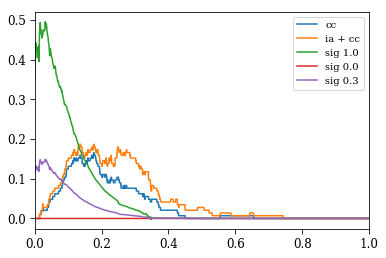

In [59]:
#plot redshift distribution pdfs to check accuracy
plt.figure()
plt.plot(bg_z, bkg_pdf(bg_z), label='cc')
plt.plot(bg_z, bia_pdf(bg_z), label='ia + cc')
plt.plot(signal_z, sig_pdf(signal_z), label='sig 1.0')
plt.plot(signal_z, sig_pdf0(signal_z), label='sig 0.0')
plt.plot(signal_z, sig_pdf3(signal_z), label='sig 0.3')
plt.xlim(0., 1.)
plt.legend()
plt.show()

### Drop signal events that don't fall on a CCD

In [60]:
#Treat chip gaps and outside FoV separately
def check_sig_inside_fov(ra, dec, fov, fov_outline):
    return fov_outline.contains_points([(ra, dec)])[0]

def check_sig_on_ccds(ra, dec, fov):
    ccds = [str(int(x)) for x in np.linspace(1, 62, 62)]
    for ccd in ccds:
        coords = fov[ccd]
        x_min, x_max = coords[0][0], coords[3][0]
        if ra > x_min and ra < x_max:
            y_min, y_max = coords[0][1], coords[1][1]
            if dec > y_min and dec < y_max:
                return True
    return False

sig_truth_values = []
sig_inside = 0
for index, row in s_df.iterrows():
    if check_sig_inside_fov(row['RA'], row['DEC'], centered_deg_boundaries, outline):
        sig_inside += 1
    sig_truth_values.append(check_sig_on_ccds(row['RA'], row['DEC'], centered_deg_boundaries))
s = pd.Series(sig_truth_values)
s_df = s_df[s.values]

sig3_truth_values = []
for index, row in s_df3.iterrows():
    sig3_truth_values.append(check_sig_on_ccds(row['RA'], row['DEC'], centered_deg_boundaries))
s3 = pd.Series(sig3_truth_values)
s_df3 = s_df3[s3.values]

In [61]:
#print(total_signal, sig_inside, s_df.shape[0])
p_outside_fov = 100. - sig_inside / total_signal * 100
p_inside_fov_but_on_gaps = (sig_inside - s_df.shape[0]) / total_signal * 100
f_remaining_sig = s_df.shape[0] / total_signal
print('Percent of Signal outside FoV:  %.2f %%' %p_outside_fov)
print('Percent of Signal on chip gaps: %.2f %%' %p_inside_fov_but_on_gaps)
print('\nFraction of Signal on a CCD:  %.2f' %f_remaining_sig)

Percent of Signal outside FoV:  0.96 %
Percent of Signal on chip gaps: 11.93 %

Fraction of Signal on a CCD:  0.87


### Plot positions of events

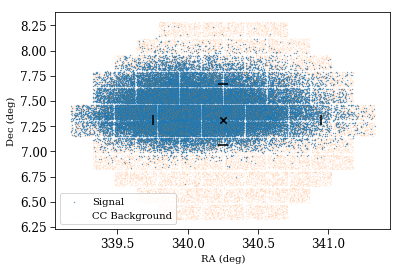

In [62]:
#Check distribution of RA and Dec
if event_num == 1:
    alert_ra = 77.43
    alert_dec = 5.72
    ra_error = (0.65, 0.95) # (-/+)
    dec_error = (0.3, 0.5) # (-/+)
if event_num == 2:
    alert_ra = 340.25
    alert_dec = 7.314
    ra_error = (0.5, 0.7) # (-/+) 
    dec_error = (0.25, 0.35) # (-/+)

plt.figure()
plt.scatter(s_df['RA'], s_df['DEC'], label='Signal', s=0.1)
plt.scatter(b_df['RA'], b_df['DEC'], label='CC Background', s=0.001)
plt.scatter(alert_ra, alert_dec, color='black', marker='x', s=40)
plt.scatter([alert_ra - ra_error[0], alert_ra + ra_error[1]], [alert_dec, alert_dec], color='black', marker='|', s=100)
plt.scatter([alert_ra, alert_ra], [alert_dec - dec_error[0], alert_dec + dec_error[1]], color='black', marker='_', s=100)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend()
plt.show()

### Plot the distributions using the DataFrames to check distribution accuracy

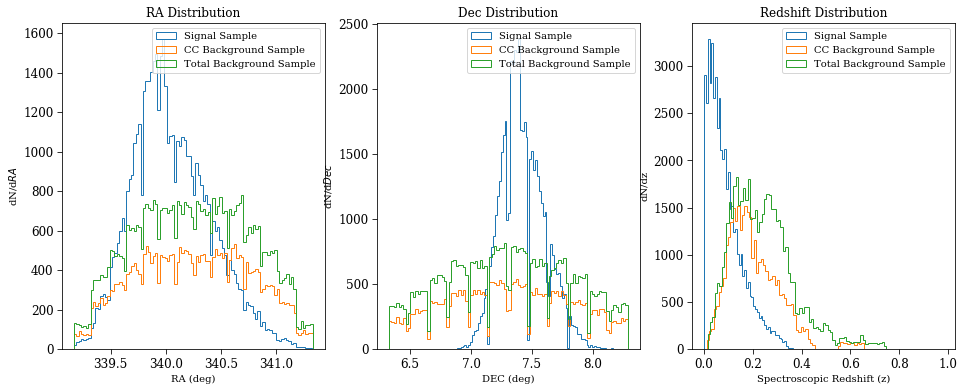

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
ax1.set_title('RA Distribution')
ax1.hist(s_df['RA'], histtype='step', label='Signal Sample', bins=100)
ax1.hist(b_df['RA'], histtype='step', label='CC Background Sample', bins=100)
ax1.hist(b_tot_df['RA'], histtype='step', label='Total Background Sample', bins=100)
ax1.set_xlabel('RA (deg)')
ax1.set_ylabel(r'dN/d$RA$')
ax1.legend()
ax2.set_title('Dec Distribution')
ax2.hist(s_df['DEC'], histtype='step', label='Signal Sample', bins=100)
ax2.hist(b_df['DEC'], histtype='step', label='CC Background Sample', bins=100)
ax2.hist(b_tot_df['DEC'], histtype='step', label='Total Background Sample', bins=100)
ax2.set_xlabel('DEC (deg)')
ax2.set_ylabel(r'dN/d$Dec$')
ax2.legend()
ax3.set_title('Redshift Distribution')
ax3.hist(s_df['z'], histtype='step', label='Signal Sample', bins=100)
ax3.hist(b_df['z'], histtype='step', label='CC Background Sample', bins=100)
ax3.hist(b_tot_df['z'], histtype='step', label='Total Background Sample', bins=100)
ax3.set_xlabel('Spectroscopic Redshift (z)')
ax3.set_ylabel('dN/dz')
ax3.legend()
plt.savefig('S_B_Distributions.png')
plt.show()


### Function to obtain expected events based on redshift and postion

In [64]:
#Make sure to use CC BG when calling this function
def get_S_B(z, ra, dec, s_df, b_df):
    b_z_bounds = (b_df['z'] > z - 0.05) & (b_df['z'] < z + 0.05)
    s_z_bounds = (s_df['z'] > z - 0.05) & (s_df['z'] < z + 0.05)
    b_ra_bounds = (b_df['RA'] > ra - 0.316) & (b_df['RA'] < ra + 0.316)
    s_ra_bounds = (s_df['RA'] > ra - 0.316) & (s_df['RA'] < ra + 0.316)
    b_dec_bounds = (b_df['DEC'] > dec - 0.316) & (b_df['DEC'] < dec + 0.316)
    s_dec_bounds = (s_df['DEC'] > dec - 0.316) & (s_df['DEC'] < dec + 0.316)
    
    s = s_df[(s_z_bounds & s_ra_bounds & s_dec_bounds)].shape[0] / 10000
    b = b_df[(b_z_bounds & b_ra_bounds & b_dec_bounds)].shape[0] / 10000
    
    return s, b

### Function to obtain expected events based on only position

In [65]:
#Make sure to use total BG when calling this function
def get_S_B_nospec(ra, dec, s_df, b_df):
    b_ra_bounds = (b_df['RA'] > ra - 0.316) & (b_df['RA'] < ra + 0.316)
    s_ra_bounds = (s_df['RA'] > ra - 0.316) & (s_df['RA'] < ra + 0.316)
    b_dec_bounds = (b_df['DEC'] > dec - 0.316) & (b_df['DEC'] < dec + 0.316)
    s_dec_bounds = (s_df['DEC'] > dec - 0.316) & (s_df['DEC'] < dec + 0.316)
    
    s = s_df[(s_ra_bounds & s_dec_bounds)].shape[0] / 100000  #check this division, guessing it should be different from spec
    b = b_df[(b_ra_bounds & b_dec_bounds)].shape[0] / 100000  #case by a factor of 10 since we don't bin by redshift
    
    return s, b

## MAIN BODY

In [66]:
def collect_si_bi(df, s_df, b_df, limit_spec=False):
    #Calculate expected events in each candidate bin
    df['Si'], df['Bi'], df['Spec'] = 0.0, 0.0, True
    for index, row in df.iterrows():
        row = row.copy()
        si, bi = get_S_B(row['z'], row['RA'], row['DEC'], s_df, b_df)
        df.loc[index, 'Si'] = si
        df.loc[index, 'Bi'] = bi
        
    #Re-evaluate bin counts based on spec info availability
    chance_of_having_spec = -1
    if limit_spec:
        for index, row in df.iterrows():
            spec = random.randint(0,100) < chance_of_having_spec
            df.loc[index, 'Spec'] = spec
            if not spec:
                row = row.copy()
                si, bi = get_S_B_nospec(row['RA'], row['DEC'], s_df, b_df)
                df.loc[index, 'Si'] = si
                df.loc[index, 'Bi'] = bi
    else:
        #In the case where we have spec we can add a photo-z cut
        df = df[df['z'] < 0.2]

In [67]:
#function to calculate log likelihood as a function of lambda using np broadcasting
def get_log_likelihoods(lambdas, n_sig, n_bkg, n_bkg_ia, s_df, b_df, b_tot_df, f):
    #Combine candidate choice arrays
    candidates = np.vstack([n_sig, n_bkg, n_bkg_ia])
            
    #Sample DataFrames
    if s_df.shape[0] != 0: sig_dfs = [s_df.sample(s) for s in n_sig]
    else: 
        sig_dfs = []
        for s in n_sig: sig_dfs.append(s_df.copy())
    bkg_dfs = [b_df.sample(b) for b in n_bkg]
    bkg_dfs_tot = [b_tot_df.sample(b) for b in n_bkg_ia]
    
    counter, dfs_spec, dfs_no_spec = 0, [], []
    while counter < len(sig_dfs):
        dfs_spec.append(pd.concat([sig_dfs[counter], bkg_dfs[counter]]))
        dfs_no_spec.append(pd.concat([sig_dfs[counter], bkg_dfs_tot[counter]]))
        counter+=1
    
    #Collect Expected events for spec versus no spec
    for df in dfs_spec:
        collect_si_bi(df, s_df, b_df)
    for df in dfs_no_spec:
        collect_si_bi(df, s_df, b_tot_df, limit_spec=True)
        
    #Separate empty and nonempty dataframes
    dfs_non_empty = [x for x in dfs_spec if x.shape[0] > 0]
    dfs_empty = [x for x in dfs_spec if x.shape[0] == 0]
    dfs_no_spec_non_empty = [x for x in dfs_no_spec if x.shape[0] > 0]
    dfs_no_spec_empty = [x for x in dfs_no_spec if x.shape[0] == 0]
    
    #Now for each lambda value we need to calculate the log likelihood
    log_likelihoods = []
    for df in dfs_non_empty:
        l = np.zeros(lambdas.shape)
        for index, row in df.iterrows():
            l += np.log(lambdas * row['Si'] + row['Bi'])
        log_likelihoods.append(-1.0 * f * lambdas + l)
    log_likelihoods_no_spec = []
    for df in dfs_no_spec_non_empty:
        l = np.zeros(lambdas.shape)
        for index, row in df.iterrows():
            l += np.log(lambdas * row['Si'] + row['Bi'])
        log_likelihoods_no_spec.append(-1.0 * f * lambdas + l)
    
    for x in dfs_empty:
        log_likelihoods.append(-1.0 * f * lambdas)
    for x in dfs_empty:
        log_likelihoods_no_spec.append(-1.0 * f * lambdas)
        
    #collect dfs into list
    dfs = [dfs_non_empty, dfs_empty, dfs_no_spec_non_empty, dfs_no_spec_empty]
    
    return dfs, np.asarray(log_likelihoods), np.asarray(log_likelihoods_no_spec)

In [68]:
s_df['S_vs_B'] = 'S'
s_df0['S_vs_B'] = 'S'
s_df3['S_vs_B'] = 'S'
b_df['S_vs_B'] = 'B'
b_tot_df['S_vs_B'] = 'B'

f = s_df.shape[0] / total_signal * sig_auc
f0 = s_df0.shape[0] / total_signal * sig_auc0 #0.0
f3 = s_df3.shape[0] / total_signal * sig_auc3

n_sig_candidates = np.linspace(0.0, 1.0, 2)
n_bkg_candidates = np.linspace(0.0, 10.0, 11)
#ns_prob = poisson.pmf(k=n_sig_candidates, mu=sig_auc)   #change to using auc as prob for sig
nb_prob = poisson.pmf(k=n_bkg_candidates, mu=bkg_auc)
nb_ia_prob = poisson.pmf(k=n_bkg_candidates, mu=bia_auc)

#normalize probabilities
#ns_prob = ns_prob / np.sum(ns_prob)
ns_prob = np.asarray([1.0 - sig_auc, sig_auc])
ns_prob0 = np.asarray([1.0 - sig_auc0, sig_auc0])
ns_prob3 = np.asarray([1.0 - sig_auc3, sig_auc3])
nb_prob = nb_prob / np.sum(nb_prob)
nb_ia_prob = nb_ia_prob / np.sum(nb_ia_prob)

#Consider different numbers of realizations
M_realizations = [1000] #[10, 100, 1000]

#Consider different true values of lambda
lambda_true = [0.0, 0.3, 1.0]

#Let's suppose each realization is 100 alerts
N_alerts = 50

print('Simulating %i realizations of %i alerts for lambda =' %(M_realizations[0], N_alerts), lambda_true, '\n')



Simulating 1000 realizations of 50 alerts for lambda = [0.0, 0.3, 1.0] 



In [69]:
##################################################################### lambda_true == 1.0
TS_dist_dict = {}
r_counter = 1
for n_realization in M_realizations:
    counter = 0
    TS_dist = []
    TS_no_spec_dist = []
    while counter < n_realization:
        #Select the number of candidates for each alert
        n_sig = np.asarray([int(x) for x in np.random.choice(n_sig_candidates, N_alerts, p=ns_prob)])
        n_bkg = np.asarray([int(x) for x in np.random.choice(n_bkg_candidates, N_alerts, p=nb_prob)])
        n_bkg_ia = np.asarray([int(x) for x in np.random.choice(n_bkg_candidates, N_alerts, p=nb_ia_prob)])
        
        #Keep track of the log-likelihood as a function of lambda for each alert
        lambdas = np.linspace(0.0, 1.0, 11)
        dfs, log_likelihoods, log_likelihoods_no_spec = get_log_likelihoods(lambdas, n_sig, n_bkg, n_bkg_ia, s_df, b_df, b_tot_df, f)
        
        #Calculate global log likelihoods for the realization for each value of lambda
        global_ll = np.sum(log_likelihoods, axis=0)
        global_ll_no_spec = np.sum(log_likelihoods_no_spec, axis=0)
        
        #Calculate TS for each realization from delta global log likelihood
        TS = np.max(global_ll) - global_ll[0]
        TS_no_spec = np.max(global_ll_no_spec) - global_ll_no_spec[0]
        
        #Save test statistics
        TS_dist.append(np.sqrt([TS])[0])
        TS_no_spec_dist.append(np.sqrt([TS_no_spec])[0])
        
        #Update counter
        counter += 1
        sys.stdout.write('\r'+'lambda=1.0 set %i realization %i   ' %(r_counter, counter))

    #Save results for each set of realizations to a dictionary
    TS_dist_dict['TS_%i_spec' %n_realization] = TS_dist[:]
    TS_dist_dict['TS_%i_no_spec' %n_realization] = TS_no_spec_dist[:]
    
    r_counter += 1
    #print('realization set %i' %r_counter)
    


lambda=1.0 set 1 realization 1000   

In [70]:
##################################################################### lambda_true == 0.3
print(' ')
TS_dist_dict3 = {}
r_counter = 1
for n_realization in M_realizations:
    counter = 0
    TS_dist = []
    TS_no_spec_dist = []
    while counter < n_realization:
        #Select the number of candidates for each alert
        n_sig = np.asarray([int(x) for x in np.random.choice(n_sig_candidates, N_alerts, p=ns_prob3)])
        n_bkg = np.asarray([int(x) for x in np.random.choice(n_bkg_candidates, N_alerts, p=nb_prob)])
        n_bkg_ia = np.asarray([int(x) for x in np.random.choice(n_bkg_candidates, N_alerts, p=nb_ia_prob)])
        
        #Keep track of the log-likelihood as a function of lambda for each alert
        lambdas = np.linspace(0.0, 1.0, 11)
        dfs, log_likelihoods, log_likelihoods_no_spec = get_log_likelihoods(lambdas, n_sig, n_bkg, n_bkg_ia, s_df, b_df, b_tot_df, f)
        
        #Calculate global log likelihoods for the realization for each value of lambda
        global_ll = np.sum(log_likelihoods, axis=0)
        global_ll_no_spec = np.sum(log_likelihoods_no_spec, axis=0)
        
        #Calculate TS for each realization from delta global log likelihood
        TS = np.max(global_ll) - global_ll[0]
        TS_no_spec = np.max(global_ll_no_spec) - global_ll_no_spec[0]
        
        #Save test statistics
        TS_dist.append(np.sqrt([TS])[0])
        TS_no_spec_dist.append(np.sqrt([TS_no_spec])[0])
        
        #Update counter
        counter += 1
        sys.stdout.write('\r'+'lambda=0.3 set %i realization %i   ' %(r_counter, counter))

    #Save results for each set of realizations to a dictionary
    TS_dist_dict3['TS_%i_spec' %n_realization] = TS_dist[:]
    TS_dist_dict3['TS_%i_no_spec' %n_realization] = TS_no_spec_dist[:]
    
    r_counter += 1
    #print('realization set %i' %r_counter)
    


 
lambda=0.3 set 1 realization 1000   

In [71]:
####################################################################3 lambda_true == 0.0
print(' ')
TS_dist_dict0 = {}
r_counter = 1
for n_realization in M_realizations:
    counter = 0
    TS_dist = []
    TS_no_spec_dist = []
    while counter < n_realization:
        #Select the number of candidates for each alert
        n_sig = np.asarray([int(x) for x in np.random.choice(n_sig_candidates, N_alerts, p=ns_prob0)])
        n_bkg = np.asarray([int(x) for x in np.random.choice(n_bkg_candidates, N_alerts, p=nb_prob)])
        n_bkg_ia = np.asarray([int(x) for x in np.random.choice(n_bkg_candidates, N_alerts, p=nb_ia_prob)])
        
        #Keep track of the log-likelihood as a function of lambda for each alert
        lambdas = np.linspace(0.0, 1.0, 11)
        dfs, log_likelihoods, log_likelihoods_no_spec = get_log_likelihoods(lambdas, n_sig, n_bkg, n_bkg_ia, s_df, b_df, b_tot_df, f)
        
        #Calculate global log likelihoods for the realization for each value of lambda
        global_ll = np.sum(log_likelihoods, axis=0)
        global_ll_no_spec = np.sum(log_likelihoods_no_spec, axis=0)
        
        #Calculate TS for each realization from delta global log likelihood
        TS = np.max(global_ll) - global_ll[0]
        TS_no_spec = np.max(global_ll_no_spec) - global_ll_no_spec[0]
        
        #Save test statistics
        TS_dist.append(np.sqrt([TS])[0])
        TS_no_spec_dist.append(np.sqrt([TS_no_spec])[0])
        
        #Update counter
        counter += 1
        sys.stdout.write('\r'+'lambda=0.0 set %i realization %i   ' %(r_counter, counter))

    #Save results for each set of realizations to a dictionary
    TS_dist_dict0['TS_%i_spec' %n_realization] = TS_dist[:]
    TS_dist_dict0['TS_%i_no_spec' %n_realization] = TS_no_spec_dist[:]
    
    r_counter += 1
    #print('realization set %i' %r_counter)



print('\nDone!')

 
lambda=0.0 set 1 realization 1000   
Done!


### Plot results

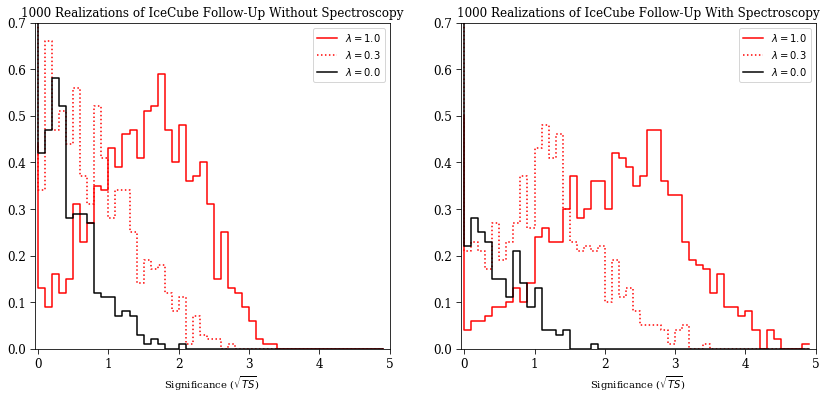

In [72]:
n_bins = 50

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6))
ax1.set_title('1000 Realizations of IceCube Follow-Up Without Spectroscopy')
ax2.set_title('1000 Realizations of IceCube Follow-Up With Spectroscopy')
for M in M_realizations:
    ax2.plot(np.linspace(0, 4.9, n_bins), np.histogram(TS_dist_dict['TS_%i_spec' %M], density=True, range=(0., 5.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='red', label='$\lambda = 1.0$')
    ax2.plot(np.linspace(0, 4.9, n_bins), np.histogram(TS_dist_dict3['TS_%i_spec' %M], density=True, range=(0., 5.), bins=n_bins)[0], ls='dotted', drawstyle='steps', color='red', label='$\lambda = 0.3$')
    ax2.plot(np.linspace(0, 4.9, n_bins), np.histogram(TS_dist_dict0['TS_%i_spec' %M], density=True, range=(0., 5.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='black', label='$\lambda = 0.0$')
    ax1.plot(np.linspace(0, 4.9, n_bins), np.histogram(TS_dist_dict['TS_%i_no_spec' %M], density=True, range=(0., 5.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='red', label='$\lambda = 1.0$')
    ax1.plot(np.linspace(0, 4.9, n_bins), np.histogram(TS_dist_dict3['TS_%i_no_spec' %M], density=True, range=(0., 5.), bins=n_bins)[0], ls='dotted', drawstyle='steps', color='red', label='$\lambda = 0.3$')
    ax1.plot(np.linspace(0, 4.9, n_bins), np.histogram(TS_dist_dict0['TS_%i_no_spec' %M], density=True, range=(0., 5.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='black', label='$\lambda = 0.0$')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
#plt.text(2.6, 0.635, '50 Follow-Ups per Realization')
ax1.set_xlabel('Significance ($\sqrt{TS}$)')
ax1.set_xlim(-0.05, 5.0)
ax1.set_ylim(0., .7)
ax2.set_xlabel('Significance ($\sqrt{TS}$)')
ax2.set_xlim(-0.05, 5.0)
ax2.set_ylim(0., .7)

#plt.savefig('TS_distribution.png')
plt.show()

### Export dictionaries to csv files

In [73]:
outdir = data_dir + '/' + plot_data_dir + '/'
(pd.DataFrame.from_dict(data=TS_dist_dict, orient='index').to_csv('%sTS_dict1.csv' %outdir, header=False))
(pd.DataFrame.from_dict(data=TS_dist_dict3, orient='index').to_csv('%sTS_dict3.csv' %outdir, header=False))
(pd.DataFrame.from_dict(data=TS_dist_dict0, orient='index').to_csv('%sTS_dict0.csv' %outdir, header=False))

# Evaluate likelihoods for candidates

In [74]:
alert1_info = [[5429924, 78.2106, 6.5689, -9],
               #[5430283, 77.7641, 5.9078, -9],
               [5430381, 77.9885, 6.7475, -9]]

alert2_info = [[332325, 340.8978, 7.2230, -9],
               [332415, 340.3078, 7.9286, -9],
               [332416, 340.3947, 7.6820, -9], 
               [332273, 340.0175, 7.7087, -9]]


if event_num == 1:
    candidates = pd.DataFrame(data=alert1_info, columns=['SNID', 'RA', 'DEC', 'z'])
if event_num == 2:
    candidates = pd.DataFrame(data=alert2_info, columns=['SNID', 'RA', 'DEC', 'z'])
print(candidates)


     SNID        RA     DEC  z
0  332325  340.8978  7.2230 -9
1  332415  340.3078  7.9286 -9
2  332416  340.3947  7.6820 -9
3  332273  340.0175  7.7087 -9


In [75]:
collect_si_bi(candidates, s_df, b_df, limit_spec=True)
candidates['Pi'] = 'not calculated'
print(candidates)

     SNID        RA     DEC  z       Si       Bi   Spec              Pi
0  332325  340.8978  7.2230 -9  0.03353  0.04207  False  not calculated
1  332415  340.3078  7.9286 -9  0.03539  0.04267  False  not calculated
2  332416  340.3947  7.6820 -9  0.11867  0.04262  False  not calculated
3  332273  340.0175  7.7087 -9  0.16932  0.04258  False  not calculated


In [76]:
#Probabilities of each candidate
for index, row in candidates.iterrows():
    candidates.loc[index, ['Pi']] =  row['Si'] / (row['Si'] + row['Bi'])
print(candidates)

     SNID        RA     DEC  z       Si       Bi   Spec        Pi
0  332325  340.8978  7.2230 -9  0.03353  0.04207  False  0.443519
1  332415  340.3078  7.9286 -9  0.03539  0.04267  False  0.453369
2  332416  340.3947  7.6820 -9  0.11867  0.04262  False  0.735755
3  332273  340.0175  7.7087 -9  0.16932  0.04258  False  0.799056


In [77]:
likelihood = -1.0 * f - np.sum(np.log(np.asarray([1.0 - float(x) for x in candidates['Pi'].values])))
print(likelihood)
print(np.sqrt(likelihood))

4.073605578421398
2.0183175117957526


In [78]:
alert1_likelihood = 0.1502101733091629
alert2_likelihood = 4.073605578421398

In [79]:
# make a custom chi2 distribution
chi2_custom = np.asarray([0.5 * chi2.pdf(x, 1) for x in np.linspace(0.0, 1000.0, 100001)])
chi2_custom_func = scipy.interpolate.interp1d(np.linspace(0.0, 1000.0, 100001), chi2_custom, bounds_error=False, fill_value=0.00001)
pval = quad(chi2_custom_func, likelihood, 1000.)[0]

In [80]:
print("p-value:", pval)
print("Power:  ", 1.0 - pval)

p-value: 0.021779179409307983
Power:   0.978220820590692


In [81]:
alert1_pval = 0.34918280448359174
alert2_pval = 0.021779179409307983

In [82]:
#Calculate Global significance
#alert1_likelihood = 0.1502101733091629 #0.363652401309 #0.480437676549
#alert2_likelihood = 1.82588776944
global_likelihood = alert1_likelihood + alert2_likelihood
pval = quad(chi2_custom_func, global_likelihood, 1000.)[0]

print("Global Likelihood: ", global_likelihood)
print("Global p-value:    ", pval)
print("Global Power:      ", 1.0-pval)

Global Likelihood:  4.223815751730561
Global p-value:     0.019930282140440004
Global Power:       0.98006971785956


# Preliminary NSF GRFP Plot

In [76]:
dict1 = pd.read_csv('TS_dict1.csv', header=None)
s1 = np.asarray(dict1.values[0][1:])
n1 = np.asarray(dict1.values[1][1:])

dict0 = pd.read_csv('TS_dict0.csv', header=None)
s0 = np.asarray(dict0.values[0][1:])
n0 = np.asarray(dict0.values[1][1:])

dict3 = pd.read_csv('TS_dict3.csv', header=None)
s3 = np.asarray(dict3.values[0][1:])
n3 = np.asarray(dict3.values[1][1:])

w2 = n1 * 1.45
w1 = 1.45 * s1
#l1 = 1.5 * w1

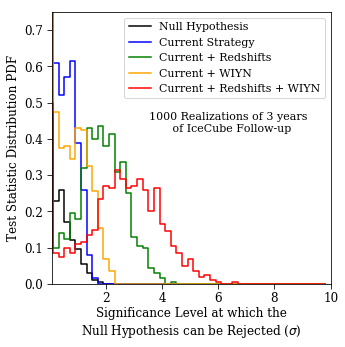

In [91]:
n_bins=50
plt.figure(figsize=(5,5))
plt.step(np.linspace(0, 9.8, n_bins), np.histogram(s0, density=True, range=(0., 10.), bins=n_bins)[0], where='mid', color='black', label='Null Hypothesis')
plt.step(np.linspace(0, 9.8, n_bins), np.histogram(n1, density=True, range=(0., 10.), bins=n_bins)[0], where='mid', color='blue', label='Current Strategy')
plt.step(np.linspace(0, 9.8, n_bins), np.histogram(s1, density=True, range=(0., 10.), bins=n_bins)[0], where='mid', color='green', label='Current + Redshifts')
plt.step(np.linspace(0, 9.8, n_bins), np.histogram(w2, density=True, range=(0., 10.), bins=n_bins)[0], where='mid', color='orange', label='Current + WIYN')
plt.step(np.linspace(0, 9.8, n_bins), np.histogram(w1, density=True, range=(0., 10.), bins=n_bins)[0], where='mid', color='red', label='Current + Redshifts + WIYN')
#plt.plot(np.linspace(0, 9.8, n_bins), np.histogram(l1, density=True, range=(0., 10.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='red', label='Current + Spec + WIYN + ComCam')
plt.ylim(0., 0.75)
plt.xlim(0.05, 10.)
plt.xlabel('Significance Level at which the\nNull Hypothesis can be Rejected ($\sigma$)', fontsize=12)
plt.ylabel('Test Statistic Distribution PDF', fontsize=12)
plt.text(6.4, 0.42, '1000 Realizations of 3 years \n of IceCube Follow-up', horizontalalignment='center', fontsize=11)
plt.legend(fontsize=11)
plt.savefig('NSF-GRFP_Plot.png')
plt.show()


In [ ]:
M_realizations = [1000]
n_bins = 50

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6))
ax1.set_title('IceCube Follow-Up Without Spectroscopy')
ax2.set_title('IceCube Follow-Up With Spectroscopy')
for M in M_realizations:
    ax2.plot(np.linspace(0, 4.9, n_bins), np.histogram(s1, density=True, range=(0., 5.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='red', label='$\lambda = 1.0$')
    ax2.plot(np.linspace(0, 4.9, n_bins), np.histogram(s3, density=True, range=(0., 5.), bins=n_bins)[0], ls='dotted', drawstyle='steps', color='red', label='$\lambda = 0.3$')
    ax2.plot(np.linspace(0, 4.9, n_bins), np.histogram(s0, density=True, range=(0., 5.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='black', label='$\lambda = 0.0$')
    ax1.plot(np.linspace(0, 4.9, n_bins), np.histogram(n1, density=True, range=(0., 5.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='red', label='$\lambda = 1.0$')
    ax1.plot(np.linspace(0, 4.9, n_bins), np.histogram(n3, density=True, range=(0., 5.), bins=n_bins)[0], ls='dotted', drawstyle='steps', color='red', label='$\lambda = 0.3$')
    ax1.plot(np.linspace(0, 4.9, n_bins), np.histogram(n0, density=True, range=(0., 5.), bins=n_bins)[0], ls='solid', drawstyle='steps', color='black', label='$\lambda = 0.0$')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
#plt.text(2.6, 0.635, '50 Follow-Ups per Realization')
ax1.set_xlabel('Significance ($\sqrt{TS}$)')
ax1.set_xlim(-0.01, 5.0)
ax1.set_ylim(0., .7)
ax2.set_xlabel('Significance ($\sqrt{TS}$)')
ax2.set_xlim(-0.01, 5.0)
ax2.set_ylim(0., .7)

plt.savefig('TS_distribution.png')
plt.show()